# Visualizing momentum

In [12]:
import jax
import jax.numpy as jnp
from diffrax import diffeqsolve, Tsit5, ODETerm, SaveAt, PIDController
import optax
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

## Setup and helper functions

In [13]:
#shape of wire
f = lambda x:  1. - 4.14678 * x + 19.139 * x**2 - 35.7261 * x**3 + 20.4149 * x**4
f_x = jax.grad(f)
f_xx = jax.grad(f_x)

#for plotting
x_surface = jnp.linspace(0, 1., 200)
y_surface = f(x_surface)

#animate function
def animate(xs, ys, title='Bead on a wire'):
    fig, ax = plt.subplots()
    scat = ax.scatter([], [], color='black')

    def init():
        ax.set_xlim(0, 1)
        ax.set_ylim(-0.1, 1.1)
        ax.set_title(title)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.plot(x_surface, y_surface, alpha = 0.5, color = 'black')
        return scat,

    def update(frame):
        scat.set_offsets(np.array([[xs[frame], ys[frame]]]))
        return scat,

    ani = FuncAnimation(fig, update, frames=len(xs), init_func=init, 
                        blit=True, interval = 1)

    # Save the animation as a GIF
    ani.save(title+'.gif', writer='pillow')

def solve_field(vector_field, phase0, args, t0, t1, n_t = 200):
    sol = diffeqsolve(ODETerm(vector_field), Tsit5(), t0, t1, 0.1, phase0, 
                  args = args, saveat = SaveAt(ts=jnp.linspace(t0, t1, n_t)),
                  stepsize_controller = PIDController(rtol=1e-5, atol=1e-5))
    return sol

## Fields:

In [14]:
@jax.jit
def gd_field(t, phase, args):
    eta = args
    x, y = phase
    theta = jnp.arctan(f_x(x))
    x_dot = -eta*f_x(x)*jnp.cos(theta)
    y_dot = -eta*f_x(x)*jnp.sin(theta)
    phase_dot = (x_dot, y_dot)
    return phase_dot

@jax.jit
def momentum_field(t, phase, args):
    m, eta, mu = args
    x, y, x_dot, y_dot = phase
    theta = jnp.arctan(f_x(x))
    N = (f_xx(x)*(x_dot**2) + (eta/m)*f_x(x)*(jnp.sin(theta) - f_x(x)*jnp.cos(theta)))/\
        (jnp.cos(theta) + f_x(x)*jnp.sin(theta))
    x_dotdot = - N*jnp.sin(theta) - (mu/m)*x_dot - (eta/m)*f_x(x)*jnp.cos(theta)
    y_dotdot = N*jnp.cos(theta) - (mu/m)*y_dot - (eta/m)*f_x(x)*jnp.sin(theta)
    phase_dot = (x_dot, y_dot, x_dotdot, y_dotdot)
    return phase_dot 

@jax.jit
def gravity_field(t, phase, args):
    m, g, mu = args
    x, y, x_dot, y_dot = phase
    theta = jnp.arctan(f_x(x))
    N = (f_xx(x)*(x_dot**2) + g) / (jnp.cos(theta) + jnp.sin(theta)*f_x(x))
    x_dotdot = -N*jnp.sin(theta) - (mu/m)*x_dot
    y_dotdot = N*jnp.cos(theta) - (mu/m)*y_dot - g
    phase_dot = (x_dot, y_dot, x_dotdot, y_dotdot)
    return phase_dot 

## Solving:

In [15]:
t0, t1 = 0., 50.
gd_sol = solve_field(gd_field, (0., f(0.)), (1.), t0, t1)
momentum_sol = solve_field(momentum_field, (0., f(0.), 0., 0.), 
                           (1., 1., 0.75), t0, t1)
gravity_sol = solve_field(gravity_field, (0., f(0.), 0., 0.), 
                          (1., 1., 0.5), t0, t1)

## Animating:

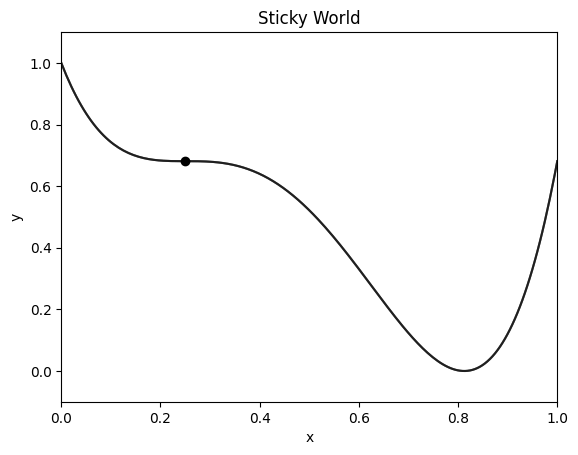

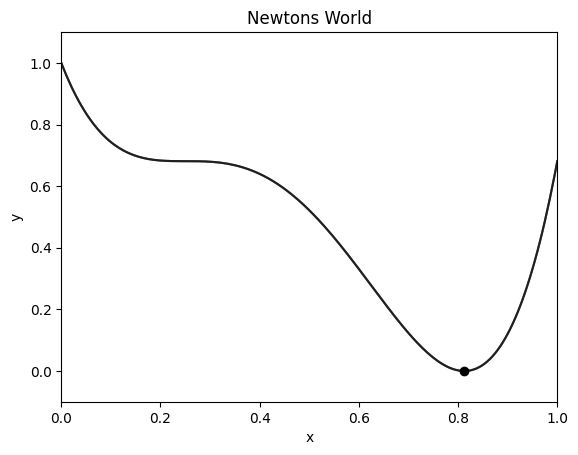

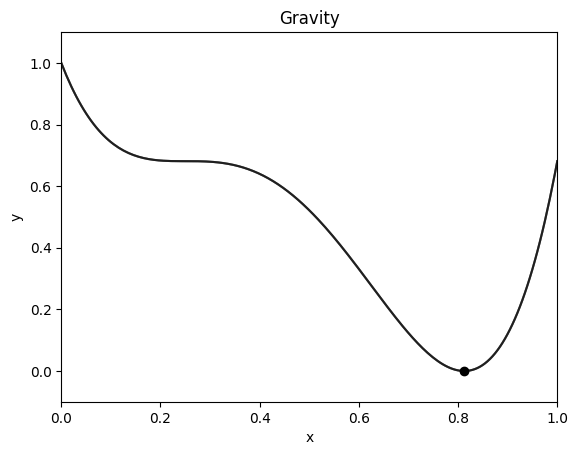

In [16]:
animate(gd_sol.ys[0], gd_sol.ys[1], 'Sticky World')
animate(momentum_sol.ys[0], momentum_sol.ys[1], 'Newtons World')
animate(gravity_sol.ys[0], gravity_sol.ys[1], 'Gravity')

## Optimizer functions:

In [17]:
def optimize(optimizer, x0, n_iterations = 200):
    state = x0  # Step size: 0.1
    opt_state = optimizer.init(state)
    x_values = [state]
    vgf = jax.value_and_grad(f)
    for _ in range(n_iterations):
        value, grads = vgf(state)
        updates, opt_state = optimizer.update(grads, opt_state)
        state = optax.apply_updates(state, updates)
        x_values.append(state)
    return jnp.array(x_values)

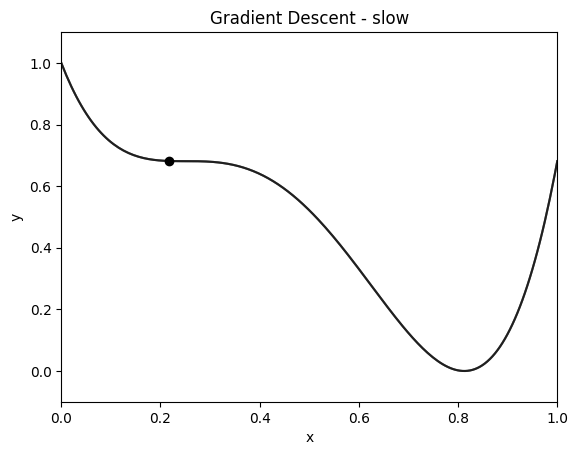

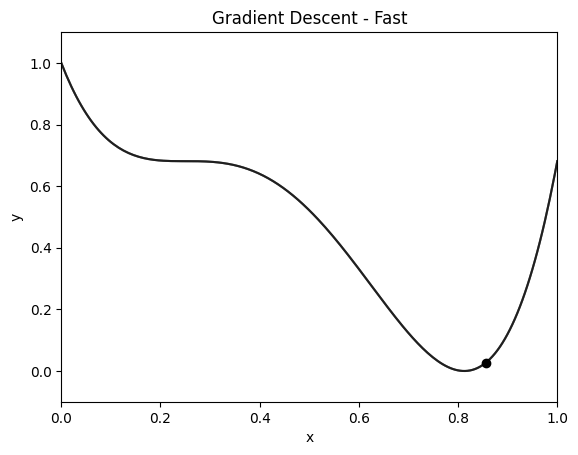

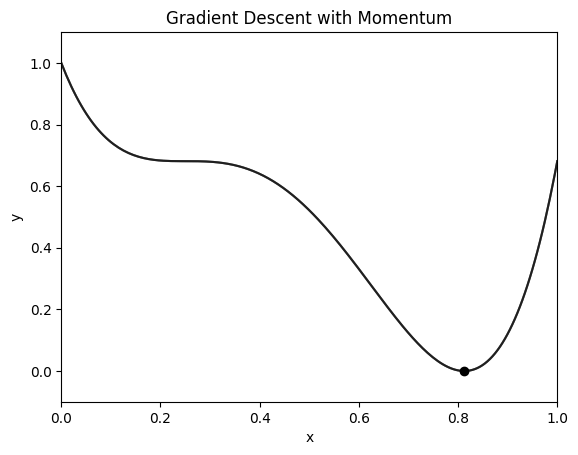

In [18]:
xt = optimize(optax.sgd(0.0025), 0., 200)
animate(xt, f(xt), 'Gradient Descent - slow')

xt = optimize(optax.sgd(0.1), 0., 200)
animate(xt, f(xt), 'Gradient Descent - Fast')

xt = optimize(optax.sgd(0.025, momentum = .6), 0., 200)
animate(xt, f(xt), 'Gradient Descent with Momentum')